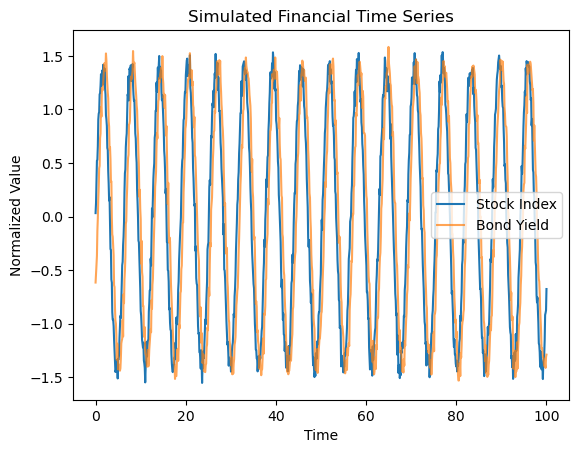

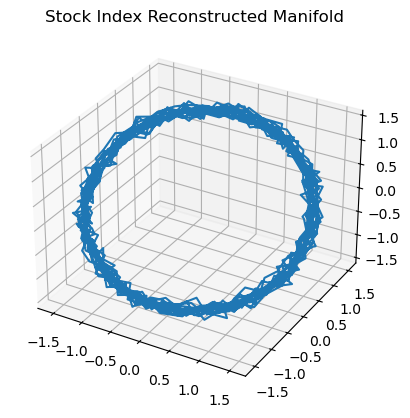

Stock Index → Bond Yield CCM Correlation: 0.86
Bond Yield → Stock Index CCM Correlation: 0.86


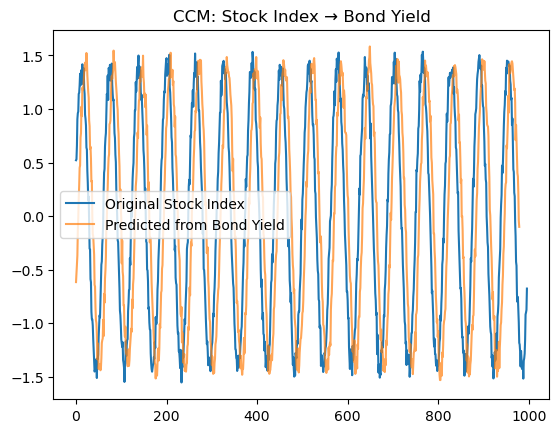

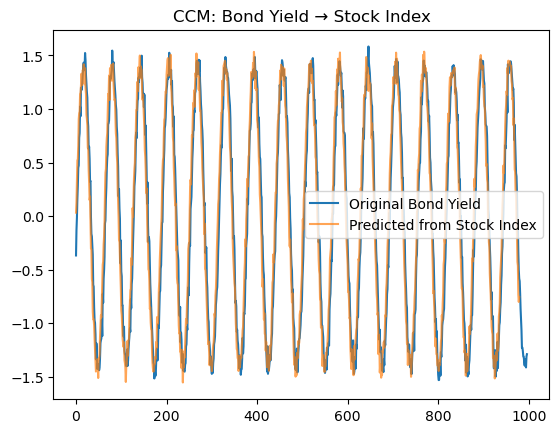

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Simulate financial time series
np.random.seed(42)
t = np.linspace(0, 100, 1000)
stock_index = np.sin(t) + 0.05 * np.random.randn(len(t))  # Stock index with noise
bond_yield = np.sin(t - np.pi / 6) + 0.05 * np.random.randn(len(t))  # Bond yield, lagged by phase shift
# Normalize the data
stock_index = (stock_index - np.mean(stock_index)) / np.std(stock_index)
bond_yield = (bond_yield - np.mean(bond_yield)) / np.std(bond_yield)
# Visualize the time series
plt.plot(t, stock_index, label="Stock Index")
plt.plot(t, bond_yield, label="Bond Yield", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.title("Simulated Financial Time Series")
plt.savefig("financial_time_series.png")
plt.show()

# Time-delay embedding function
def time_delay_embedding(series, delay, dimension):
    n = len(series)
    embedded = np.zeros((n - (dimension - 1) * delay, dimension))
    for i in range(dimension):
        embedded[:, i] = series[i * delay:n - (dimension - 1 - i) * delay]
    return embedded
# Parameters for embedding
delay = 10  # Chosen time delay
dimension = 3  # Embedding dimension
# Reconstruct manifolds
stock_manifold = time_delay_embedding(stock_index, delay, dimension)
bond_manifold = time_delay_embedding(bond_yield, delay, dimension)
# Visualize the reconstructed stock index manifold
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(stock_manifold[:, 0], stock_manifold[:, 1], stock_manifold[:, 2])
ax.set_title("Stock Index Reconstructed Manifold")
plt.savefig("stock_index_manifold.png")
plt.show()

def cross_map(source, target, delay, dimension):
    # Reconstruct the target manifold
    embedded_target = time_delay_embedding(target, delay, dimension)
    predictions = []
    for i in range(len(embedded_target)):
        # Find nearest neighbors in the embedded space
        neighbors = np.argsort(np.linalg.norm(embedded_target - embedded_target[i], axis=1))[:dimension + 1]
        # Avoid division by zero by adding a small constant
        weights = 1 / (np.linalg.norm(embedded_target[neighbors] - embedded_target[i], axis=1) + 1e-9)
        weights /= np.sum(weights)
        prediction = np.sum(weights * source[neighbors])
        predictions.append(prediction)
    return predictions

# Apply CCM
predicted_stock = cross_map(stock_index, bond_yield, delay, dimension)
predicted_bond = cross_map(bond_yield, stock_index, delay, dimension)

stock_to_bond_corr = np.corrcoef(stock_index[:len(predicted_bond)], predicted_bond)[0, 1]
bond_to_stock_corr = np.corrcoef(bond_yield[:len(predicted_stock)], predicted_stock)[0, 1]
print(f"Stock Index → Bond Yield CCM Correlation: {stock_to_bond_corr:.2f}")
print(f"Bond Yield → Stock Index CCM Correlation: {bond_to_stock_corr:.2f}")
# Visualize the CCM predictions
plt.plot(stock_index[dimension:], label="Original Stock Index")
plt.plot(predicted_bond, label="Predicted from Bond Yield", alpha=0.7)
plt.legend()
plt.title("CCM: Stock Index → Bond Yield")
plt.savefig("ccm_stock_to_bond.png")
plt.show()
plt.plot(bond_yield[dimension:], label="Original Bond Yield")
plt.plot(predicted_stock, label="Predicted from Stock Index", alpha=0.7)
plt.legend()
plt.title("CCM: Bond Yield → Stock Index")
plt.savefig("ccm_bond_to_stock.png")
plt.show()


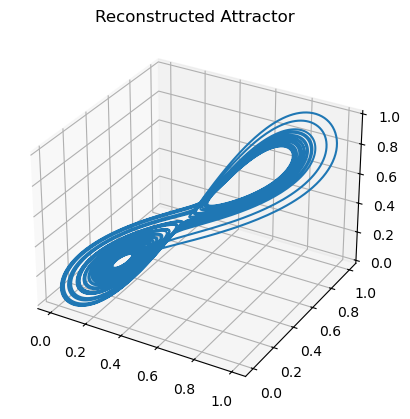

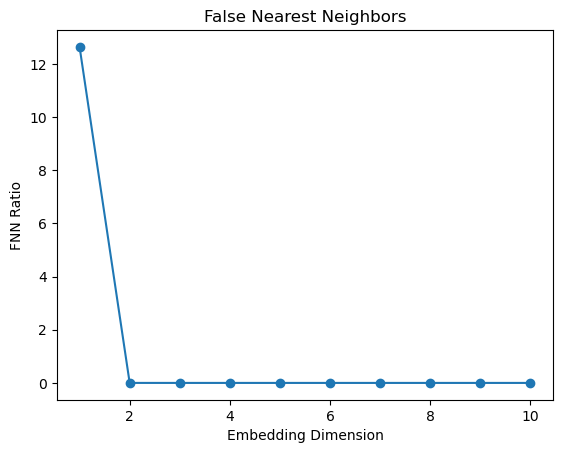

CCM Correlation: 0.98


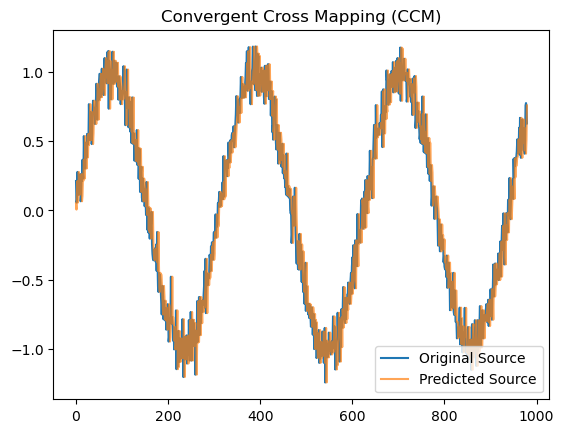

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import solve_ivp
from sklearn.metrics import pairwise_distances

# Lorenz system
def lorenz_system(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

# Time-delay embedding
def time_delay_embedding(series, delay, dimension):
    n = len(series)
    embedded = np.zeros((n - (dimension - 1) * delay, dimension))
    for i in range(dimension):
        embedded[:, i] = series[i * delay:n - (dimension - 1 - i) * delay]
    return embedded

# False Nearest Neighbors
def false_nearest_neighbors(series, delay, max_dim, threshold=10):
    n = len(series)
    fnn_ratios = []
    for dim in range(1, max_dim + 1):
        embedded = time_delay_embedding(series, delay, dim)
        distances = pairwise_distances(embedded[:-1]) + 1e-10  # Add small constant to avoid division by zero
        distances_next = pairwise_distances(embedded[1:])
        fnn_count = np.sum((distances_next / distances) > threshold)
        fnn_ratios.append(fnn_count / len(embedded))
    return fnn_ratios

# Cross Mapping
def cross_map(source, target, delay, dimension):
    embedded_target = time_delay_embedding(target, delay, dimension)
    predictions = []
    for i in range(len(embedded_target)):
        neighbors = np.argsort(np.linalg.norm(embedded_target - embedded_target[i], axis=1))[:dimension + 1]
        weights = 1 / (np.linalg.norm(embedded_target[neighbors] - embedded_target[i], axis=1) + 1e-10)
        weights /= np.sum(weights)
        prediction = np.sum(weights * source[neighbors])
        predictions.append(prediction)
    return predictions

# Generate a synthetic chaotic time series
t_span = (0, 40)
initial_state = [1.0, 1.0, 1.0]
t_eval = np.linspace(0, 40, 10000)
solution = solve_ivp(lorenz_system, t_span, initial_state, t_eval=t_eval)
time_series = solution.y[0]

# Normalize time series
scaler = MinMaxScaler()
time_series_scaled = scaler.fit_transform(time_series.reshape(-1, 1)).flatten()

# Reconstructed attractor
delay = 10
dimension = 3
embedded_data = time_delay_embedding(time_series_scaled, delay, dimension)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2])
ax.set_title("Reconstructed Attractor")
plt.savefig("reconstructed_attractor.png")
plt.show()

# FNN analysis
max_dim = 10
fnn_ratios = false_nearest_neighbors(time_series_scaled, delay, max_dim)
plt.plot(range(1, max_dim + 1), fnn_ratios, marker='o')
plt.xlabel("Embedding Dimension")
plt.ylabel("FNN Ratio")
plt.title("False Nearest Neighbors")
plt.savefig("fnn_ratios.png")
plt.show()

# Generate synthetic causally related time series
np.random.seed(42)
t = np.linspace(0, 20, 1000)
source_series = np.sin(t) + 0.1 * np.random.randn(len(t))
target_series = np.sin(t - np.pi / 4) + 0.2 * np.random.randn(len(t))

# Apply CCM
predicted_source = cross_map(source_series, target_series, delay, dimension)
# Adjust length for correlation calculation
min_length = min(len(source_series) - dimension, len(predicted_source))
correlation = np.corrcoef(source_series[dimension:dimension + min_length], predicted_source[:min_length])[0, 1]
print(f"CCM Correlation: {correlation:.2f}")

# Plot CCM results
plt.plot(source_series[dimension:dimension + min_length], label="Original Source")
plt.plot(predicted_source[:min_length], label="Predicted Source", alpha=0.7)
plt.legend()
plt.title("Convergent Cross Mapping (CCM)")
plt.savefig("ccm_results.png")
plt.show()
